# LLM

## Libraries

In [1]:
from utils import *
from process_data import *
from load_data import *

from tqdm import tqdm
import requests
import json

## Data

In [2]:
# Load data
data = "../data/BBDD_SeAcabo.csv" # "data/BBDD_SeAcabo.csv" "AMI_IBEREVAL2018/es_AMI_TrainingSet_NEW.csv"
df = load_data(data)

## Context

In [3]:
CONTEXT = "[CONTEXTO]: En agosto de 2023, tras la victoria de la Selección femenina de fútbol de España en la Copa Mundial Femenina de Fútbol de 2023, durante la celebración en la entrega de las medallas y tras abrazar efusivamente a varias jugadoras, Luis Rubiales (presidente del RFEF) besó en los labios a la centrocampista Jennifer Hermoso (jugadora) mientras sujetaba su cabeza con las manos. Hermoso lo denunció ante la Fiscalía por acoso sexual, coacciones y agresión sexual. La Fiscalía presentó una demanda contra Rubiales ante la Audiencia Nacional en Madrid"

## Prompts

In [4]:
PROMPT_1 = "[TAREA]: Tu tarea es la de clasificar tweets en clases: 'Tweet a favor de las jugadoras', 'Tweet en contra de las jugadoras' y 'Tweet neutral'"

In [5]:
PROMPT_2 = "[TAREA]: Tu tarea es la de clasificar tweets en clases: 'Tweet desprestigia acto', 'Tweet desprestigia deportista autora', 'Tweet desprestigia victima', 'Tweet insulta'"

In [6]:
PROMPT_3 = "[TAREA]: Tu tarea es la de clasificar tweets en clases: 'Tweet contiene insultos genéricos', 'Tweet contiene insultos sexistas/misoginos', 'Tweet contiene insultos con deseo de dañar'"

## Zero-shot

### Classify

In [7]:
def classify(message, context, prompt):
    url = "http://localhost:1234/v1/chat/completions"

    # Your request payload
    payload = {
        "messages": [
            {"role": "assistant", "content": context},
            {"role": "assistant", "content": prompt},
            {"role": "user", "content": f"Tweet: {message}" }
        ],
        "temperature": 0.1,
        "max_tokens": 20, ## 10
        "stream": False,
        #"model": "lmstudio-ai/gemma-2b-it-GGUF"
        "model": "lmstudio-community/Meta-Llama-3-8B-Instruct-GGUF"
    }

    headers = {
        "Content-Type": "application/json"
    }

    # Send POST request
    response = requests.post(url, headers=headers, data=json.dumps(payload))

    # Check for successful response
    if response.status_code == 200:
        return response.json()
    else:
        return {"error": "Request failed with status code " + str(response.status_code)}


In [8]:
def process_texts(df, context, prompt):
    results = []

    for text in tqdm(df['full_text'], desc="Processing Texts"):
        response = classify(text, context, prompt)
        # Extraer la respuesta del bot del objeto de respuesta
        bot_response = response.get("choices")[0].get("message").get("content") if response.get("choices") else "Sorry, I couldn't get a response."
        results.append(bot_response)
    return results

### Análisis General

In [9]:
analisis_general_df,_ = filter_by_type(df, "analisis_general", "downsampling")


Soporte de etiquetas con nombres originales:
Comentario Positivo: 435
Comentario Negativo: 435


c:\Users\jorge\Desktop\UNI\4-CUARTO\4-2-TFG\CODE\Gender-Bias\MachineLearning\process_data.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = labels


In [10]:
# Aplicar la función al DataFrame
analisis_general_df['analisis_general_pred'] = process_texts(analisis_general_df, context=CONTEXT, prompt=PROMPT_1)
print(df)

Processing Texts: 100%|██████████| 870/870 [1:02:21<00:00,  4.30s/it]


             Autora                                          full_text  \
0     Jenni Hermoso  @Jennihermoso TODA ESPAÑA ESTÁ CONTIGO https:/...   
1     Jenni Hermoso  @Jennihermoso Espero que te llegue todo el arr...   
2     Jenni Hermoso                       @Jennihermoso No estás sola💜   
3     Jenni Hermoso         @Araujismoo @Jennihermoso She’s a legend .   
4     Jenni Hermoso  @Jennihermoso Dilo, reina https://t.co/GasZHE70bE   
...             ...                                                ...   
2667    Eva Navarro        @evaaanavarro @Paulaa_311 @Jennihermoso 💜💪🏽   
2668    Eva Navarro  @evaaanavarro @Jennihermoso Z https://t.co/9vH...   
2669    Eva Navarro  @evaaanavarro @Jennihermoso Doblemente campeon...   
2670    Eva Navarro  @evaaanavarro @Jennihermoso Brava!! Siempre co...   
2671    Eva Navarro  @evaaanavarro @Jennihermoso Y después de ver e...   

         Análisis General     Contenido Negativo        Insultos  Insulto 1  \
0     Comentario Positivo       

In [11]:
analisis_general_df['analisis_general_pred'] = analisis_general_df['analisis_general_pred'].apply(lambda x: "Comentario Positivo" if 'favor' in x.lower() else "Comentario Negativo")

In [13]:
from sklearn.metrics import accuracy_score, f1_score

# Calcular la precisión
accuracy = accuracy_score(analisis_general_df['Análisis General'], analisis_general_df['analisis_general_pred'])
print(f"Accuracy: {accuracy}")

# Calcular la puntuación F1
f1 = f1_score(analisis_general_df['Análisis General'], analisis_general_df['analisis_general_pred'], average="weighted")
print(f"F1 Score: {f1}")


Accuracy: 0.8448275862068966
F1 Score: 0.8418690818712898


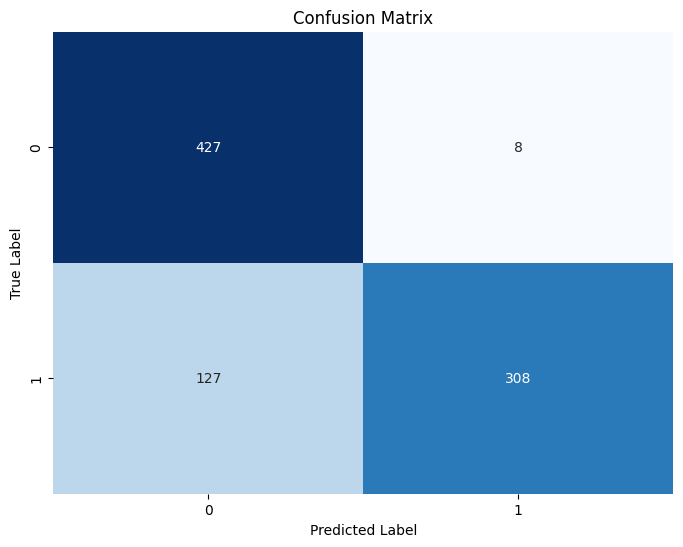

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de confusión
cm = confusion_matrix(analisis_general_df['Análisis General'], analisis_general_df['analisis_general_pred'])

# Visualizar la matriz de confusión con Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### Metrics

### Contenido Negativo

In [15]:
# Aplicar la función al DataFrame
contenido_negativo_df,_ = filter_by_type(df, "contenido_negativo", "downsampling")


Soporte de etiquetas con nombres originales:
Desprestigiar Víctima: 70
Desprestigiar Acto: 70
Insultos: 70
Desprestigiar Deportista Autora: 70


c:\Users\jorge\Desktop\UNI\4-CUARTO\4-2-TFG\CODE\Gender-Bias\MachineLearning\process_data.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Contenido Negativo'] = df['Contenido Negativo'].where(df['Contenido Negativo'].isin(etiquetas))


In [16]:
contenido_negativo_df['Contenido_Negativo_pred'] = process_texts(contenido_negativo_df, context=CONTEXT, prompt=PROMPT_2)
print(df)

Processing Texts: 100%|██████████| 280/280 [22:52<00:00,  4.90s/it]

             Autora                                          full_text  \
0     Jenni Hermoso  @Jennihermoso TODA ESPAÑA ESTÁ CONTIGO https:/...   
1     Jenni Hermoso  @Jennihermoso Espero que te llegue todo el arr...   
2     Jenni Hermoso                       @Jennihermoso No estás sola💜   
3     Jenni Hermoso         @Araujismoo @Jennihermoso She’s a legend .   
4     Jenni Hermoso  @Jennihermoso Dilo, reina https://t.co/GasZHE70bE   
...             ...                                                ...   
2667    Eva Navarro        @evaaanavarro @Paulaa_311 @Jennihermoso 💜💪🏽   
2668    Eva Navarro  @evaaanavarro @Jennihermoso Z https://t.co/9vH...   
2669    Eva Navarro  @evaaanavarro @Jennihermoso Doblemente campeon...   
2670    Eva Navarro  @evaaanavarro @Jennihermoso Brava!! Siempre co...   
2671    Eva Navarro  @evaaanavarro @Jennihermoso Y después de ver e...   

         Análisis General     Contenido Negativo        Insultos  Insulto 1  \
0     Comentario Positivo       

In [17]:
def value_pred(text):
    text = text.lower()
    if 'acto' in text:
        return "Desprestigiar Acto"
    elif 'deportista' in text or 'autora' in text:
        return "Desprestigiar Deportista Autora"
    elif 'victima' in text:
        return "Desprestigiar Víctima"
    else:
        return "Insultos"

contenido_negativo_df['Contenido_Negativo_pred'] = contenido_negativo_df['Contenido_Negativo_pred'].apply(value_pred)

In [18]:
contenido_negativo_df['Contenido_Negativo_pred'].value_counts()

Contenido_Negativo_pred
Desprestigiar Víctima              182
Insultos                            59
Desprestigiar Acto                  24
Desprestigiar Deportista Autora     15
Name: count, dtype: int64

In [19]:
contenido_negativo_df['Contenido Negativo'].value_counts()

Contenido Negativo
Insultos                           70
Desprestigiar Acto                 70
Desprestigiar Víctima              70
Desprestigiar Deportista Autora    70
Name: count, dtype: int64

#### Metrics

In [20]:
from sklearn.metrics import accuracy_score, f1_score

# Calcular la precisión
accuracy = accuracy_score(contenido_negativo_df['Contenido Negativo'], contenido_negativo_df['Contenido_Negativo_pred'])
print(f"Accuracy: {accuracy}")

# Calcular la puntuación F1
f1 = f1_score(contenido_negativo_df['Contenido Negativo'], contenido_negativo_df['Contenido_Negativo_pred'], average="weighted")
print(f"F1 Score: {f1}")


Accuracy: 0.3357142857142857
F1 Score: 0.2858972502080166


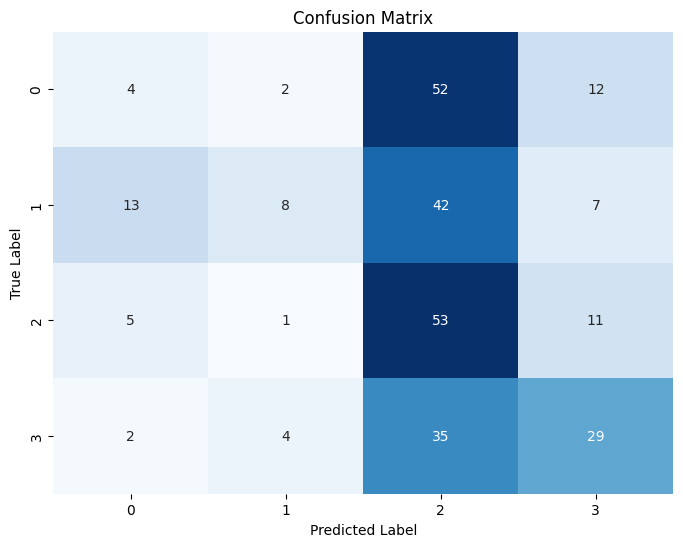

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de confusión
cm = confusion_matrix(contenido_negativo_df['Contenido Negativo'], contenido_negativo_df['Contenido_Negativo_pred'])

# Visualizar la matriz de confusión con Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### Insultos

In [29]:
# Aplicar la función al DataFrame
insults_df,_ = filter_by_type(df, "insultos", "downsampling")


Soporte de etiquetas con nombres originales:
Genéricos: 53
Sexistas/misóginos: 53
Deseo de Dañar: 53


c:\Users\jorge\Desktop\UNI\4-CUARTO\4-2-TFG\CODE\Gender-Bias\MachineLearning\process_data.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Insultos'] = df['Insultos'].where(df['Insultos'].isin(etiquetas), other="Genéricos")


In [31]:
insults_df['Insultos_pred'] = process_texts(insults_df, context=CONTEXT, prompt=PROMPT_3)
print(df)

Processing Texts: 100%|██████████| 159/159 [12:35<00:00,  4.75s/it]

             Autora                                          full_text  \
0     Jenni Hermoso  @Jennihermoso TODA ESPAÑA ESTÁ CONTIGO https:/...   
1     Jenni Hermoso  @Jennihermoso Espero que te llegue todo el arr...   
2     Jenni Hermoso                       @Jennihermoso No estás sola💜   
3     Jenni Hermoso         @Araujismoo @Jennihermoso She’s a legend .   
4     Jenni Hermoso  @Jennihermoso Dilo, reina https://t.co/GasZHE70bE   
...             ...                                                ...   
2667    Eva Navarro        @evaaanavarro @Paulaa_311 @Jennihermoso 💜💪🏽   
2668    Eva Navarro  @evaaanavarro @Jennihermoso Z https://t.co/9vH...   
2669    Eva Navarro  @evaaanavarro @Jennihermoso Doblemente campeon...   
2670    Eva Navarro  @evaaanavarro @Jennihermoso Brava!! Siempre co...   
2671    Eva Navarro  @evaaanavarro @Jennihermoso Y después de ver e...   

         Análisis General     Contenido Negativo        Insultos  Insulto 1  \
0     Comentario Positivo       

In [34]:
insults_df['Insultos_pred'].value_counts()

Insultos_pred
Clasificación: Tweet contiene insultos sexistas/misoginos.\n\nRazón:              33
Clase: 'Tweet contiene insultos sexistas/misoginos'                               14
Clasificación: Tweet contiene insultos sexistas/misoginos. El tweet utiliza un    13
Clasificación: Tweet no contiene insultos genéricos, sexistas/misoginos           11
[TAREA]: Clasificar tweet en la clase: 'Tweet contiene insultos sexistas/m        10
                                                                                  ..
Clasificación: Tweet contiene insultos sexistas/misoginos                          1
Clasificación del tweet:\n\n* Tweet contiene insultos sexistas/misoginos: S        1
Clasificación del tweet:\n\n* Tweet contiene insultos sexistas/misoginos: El       1
Clasificación del tweet: "Tweet contiene insultos genéricos" (El tweet utiliza     1
Clasificación del tweet:\n\n* Tweet contiene insultos genéricos: NO (no hay        1
Name: count, Length: 61, dtype: int64


In [33]:
insults_df['Insultos'].value_counts()

Insultos
Sexistas/misóginos    53
Deseo de Dañar        53
Genéricos             53
Name: count, dtype: int64

In [24]:
def value_pred(text):
    text = text.lower()
    if 'acto' in text:
        return "Desprestigiar Acto"
    elif 'deportista' in text or 'autora' in text:
        return "Desprestigiar Deportista Autora"
    elif 'victima' in text:
        return "Desprestigiar Víctima"
    else:
        return "Insultos"

insults_df['Insultos_pred'] = insults_df['Insultos_pred'].apply(value_pred)

#### Metrics

In [27]:
from sklearn.metrics import accuracy_score, f1_score

# Calcular la precisión
accuracy = accuracy_score(insults_df['Insultos'], insults_df['Insultos_pred'])
print(f"Accuracy: {accuracy}")

# Calcular la puntuación F1
f1 = f1_score(insults_df['Insultos'], insults_df['Insultos_pred'], average="weighted")
print(f"F1 Score: {f1}")


Accuracy: 0.0
F1 Score: 0.0


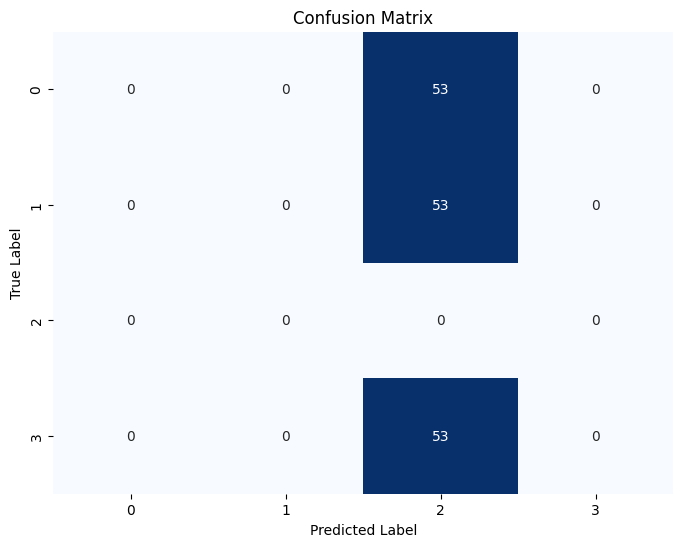

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de confusión
cm = confusion_matrix(insults_df['Insultos'], insults_df['Insultos_pred'])

# Visualizar la matriz de confusión con Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
